# fast.torch
This should be a template for training self-supervised models using PyTorch and fastai. 

In [1]:
import sys
sys.path.append('../')

from data import EMSelfPlay
from custom_transforms import RandomCutOut, GaussianBlur, ToGrayScale
from utils import show_sample, show_result, get_inpainting_transforms
from enum import Enum
from model import DynamicUnet
import numpy as np
import pandas as pd
from tqdm import tqdm

# import os
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from PIL import Image

from torchvision import models, transforms
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
# Computer SPECS
gpu_id = 1
num_cores = 4
torch.cuda.set_device(gpu_id)

## DATA

In [3]:
# hyper parameters
bs = 8  # batch size
size = 512  # image size
target_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/EM/training/trainsets/hr/')
input_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/EM/training/trainsets/lr/')

In [4]:
# Data size
len(list(input_pth.glob('*.tif'))), len(list(target_pth.glob('*.tif')))

(99997, 99997)

In [5]:
train_set = pd.read_csv('../train.csv')
valid_set = pd.read_csv('../valid.csv')
len(train_set.values), len(valid_set.values)

(79997, 20000)

In [6]:
train_set.iloc[0][0].replace('hr', 'lr')

'/home/alaa/Dropbox/BPHO Staff/USF/EM/training/trainsets/lr/EM_train_lr_14588.tif'

In [7]:
# config = {'min_n_holes': 10, 'max_n_holes': 15, 
#           'min_size': 5, 'max_size': 10}
# size = 512
# tfms = get_inpainting_transforms(size, config=config)
# print(tfms)

In [8]:
def get_pssr_transforms(size=(256,256), config=None):
    tfms = {}
    tfms['x'] = transforms.Compose([ToGrayScale(3), 
                                    transforms.Resize((600,900)),
                                    transforms.CenterCrop(size),
                                    transforms.ToTensor()])
    tfms['y'] = transforms.Compose([ToGrayScale(), 
                                    transforms.CenterCrop(size),
                                    transforms.ToTensor()])
    return tfms

size = 512
tfms = get_pssr_transforms(size)
print(tfms)

{'x': Compose(
    ToGrayScale(3)
    Resize(size=(600, 900), interpolation=PIL.Image.BILINEAR)
    CenterCrop(size=(512, 512))
    ToTensor()
), 'y': Compose(
    ToGrayScale(1)
    CenterCrop(size=(512, 512))
    ToTensor()
)}


In [9]:
class EMPSSR(Dataset):
    """A PyTorch Dataset class for self-supervised learning 
    on Electro-magnetic Microscopy Images.
    
    :param data_pth: Path object containing the absolute path to the target images
    :param transforms: Dictionary of transformations for the input and target images. 
    
    The transforms for the inputs defines the self-supervised pre-text task.
    See get_selfplay_transforms() in utils.py for an example definition.
    """

    def __init__(self, target_pth, transforms=None):
        self.target_img_filepaths = np.squeeze(target_pth).tolist()
        self.transforms = transforms
        
    def __len__(self):
        return len(self.target_img_filepaths)

    def __getitem__(self, idx):
#         if torch.is_tensor(idx):
#             idx = idx.tolist()
        input_file = self.target_img_filepaths[idx].replace('hr', 'lr')
        target_file = self.target_img_filepaths[idx]
        x = Image.open(input_file)
        y = Image.open(target_file)
        if self.transforms:
            x = self.transforms['x'](x)
            y = self.transforms['y'](y)
        return x, y

In [10]:
train_set = pd.read_csv('../train.csv').sample(frac=0.1)
train_ds = EMPSSR(train_set, tfms)

valid_set = pd.read_csv('../valid.csv').sample(frac=0.1)
valid_ds = EMPSSR(valid_set, tfms)

In [11]:
train_dl = DataLoader(train_ds, batch_size=bs,
                      shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_ds, batch_size=bs,
                      shuffle=True, num_workers=4)

In [12]:
# %debug
x, y = train_ds[200]

In [13]:
x.shape

torch.Size([3, 512, 512])

In [14]:
y.shape

torch.Size([1, 512, 512])

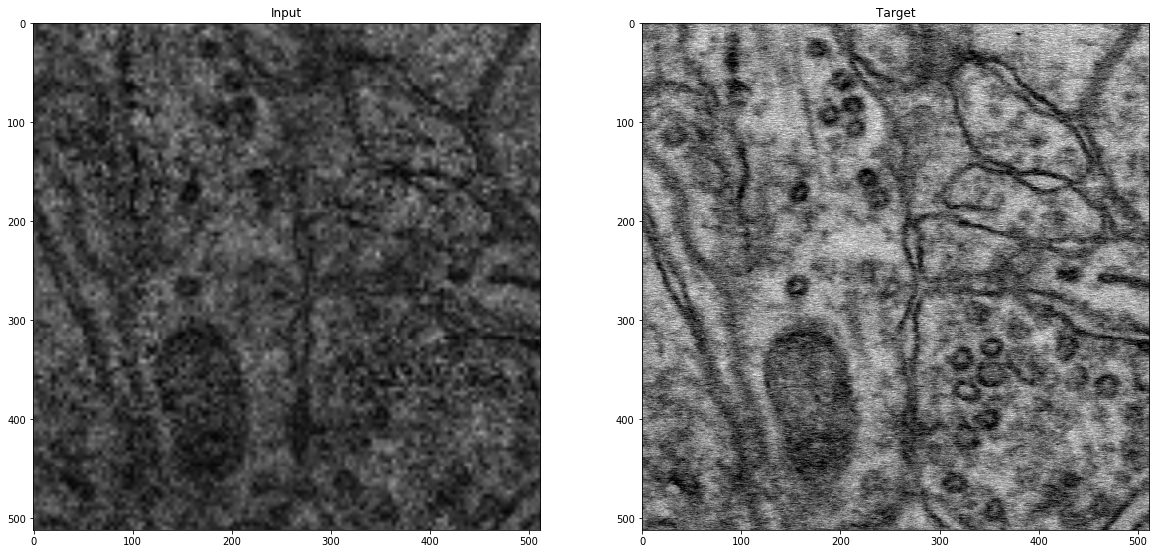

In [15]:
show_sample(train_ds)

## MODEL

In [16]:
arch = models.resnet34(True)
encoder = nn.Sequential(*list(arch.children())[:-2])
type(encoder)

torch.nn.modules.container.Sequential

In [17]:
nt = Enum('NormType', 'Batch BatchZero Weight Spectral')

In [18]:
model = DynamicUnet(encoder, n_classes=1, 
                    img_size=(size,size), norm_type=nt.Weight)

In [19]:
model

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

## TRAINING

In [20]:
def get_lrs(dataloader, max_lr=1e-3, max_mom=0.95):
    """This function returns arrays for learning rates and momentum
    following the One Cycle Policy"""
    num_batches = len(dataloader)
    lrs_up = np.linspace(max_lr/10, max_lr, num_batches // 2)
    lrs_down = np.linspace(max_lr, max_lr/10, num_batches // 2)
    
    moms_up = np.linspace(max_mom-0.1, max_mom, num_batches // 2)
    moms_down = np.linspace(max_mom, max_mom-0.1, num_batches // 2)
    total_lrs = np.concatenate([lrs_up, lrs_down])
    total_moms = np.concatenate([moms_up, moms_down])
    return total_lrs, total_moms

In [21]:
lrs, moms = get_lrs(train_dl)
# lrs[0], moms[0]

In [22]:
loss_function = F.mse_loss
optimizer = torch.optim.SGD(model.parameters(), lr=lrs[0], momentum=moms[0])

In [23]:
def validate(model, dataloader):
    running_loss = 0.0
    with tqdm(total=len(dataloader)) as pbar:
        for i, sample in enumerate(dataloader):
            x, y = sample
            x, y = x.cuda(), y.cuda()
            preds = model(x)  # [N,C]

            valid_loss = loss_function(y, preds)
            running_loss += valid_loss.item()
            pbar.update(1)
    return running_loss / (i+1)

In [69]:
# optimizer.param_groups[0]['lr'] = 1
# optimizer.param_groups[0]['lr']

In [27]:
# %debug
num_epochs = 1
total_loss = 0.0
print_every = 10
running_loss = 0.0
model.cuda()
for i in range(num_epochs):
    print("Training Model...")
    model.train()
    with tqdm(total=len(train_dl)) as pbar:
        for j, sample_batch in enumerate(train_dl):
            # get the inputs; data is a list of [inputs, labels]
            x, y = sample_batch
            x, y = x.cuda(), y.cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            preds = model(x)  # [N,C]

            loss = loss_function(y, preds)
            loss.backward()
            optimizer.step()

            # print statistics
            total_loss += loss.item()
            running_loss += loss.item()
            if j % (print_every) == 0:
                print(f'Epoch {i+1} Batch {j+1} loss: {running_loss/print_every}')
                running_loss = 0.0

            # update optimizer params
            optimizer.param_groups[0]['lr'] = lrs[j]
            optimizer.param_groups[0]['momentum'] = moms[j]
            pbar.update(1)
        
    model.eval()
    train_loss = total_loss / (j+1)
    print("Validating Model...")
    valid_loss = validate(model, valid_dl)
    print(f'Epoch {i+1} Train loss: {train_loss:.4f}, Valid loss: {valid_loss:.4f}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Training Model...


  0%|          | 1/1000 [00:01<19:59,  1.20s/it]

Epoch 1 Batch 1 loss: 0.0005605967249721289


  1%|          | 11/1000 [00:08<11:02,  1.49it/s]

Epoch 1 Batch 11 loss: 0.006104324944317341


  2%|▏         | 21/1000 [00:15<12:11,  1.34it/s]

Epoch 1 Batch 21 loss: 0.006139889964833856


  3%|▎         | 31/1000 [00:23<12:42,  1.27it/s]

Epoch 1 Batch 31 loss: 0.006259178789332509


  4%|▍         | 41/1000 [00:30<12:47,  1.25it/s]

Epoch 1 Batch 41 loss: 0.006196955498307943


  5%|▍         | 48/1000 [00:36<13:10,  1.20it/s]


KeyboardInterrupt: 

In [25]:
x, y = valid_ds[0]
x, y = x.cuda(), y.cuda()
model.eval();
pred = model(x.unsqueeze(0))

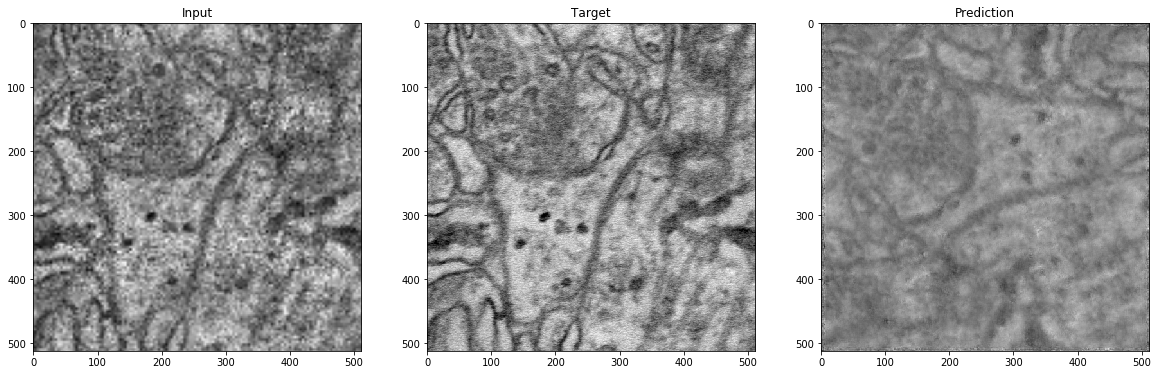

In [26]:
show_result(x, y, pred)

# DEV

In [ ]:
xis, xjs = next(iter(clr_dataloader))
xis.shape, xjs.shape

In [ ]:
model.cuda();
xis = xis.cuda()
xjs = xjs.cuda()

In [ ]:
optimizer.zero_grad()
ris, zis = model(xis)
rjs, zjs = model(xjs)
zis.shape, zjs.shape

In [61]:
zis = F.normalize(zis, dim=1)
zjs = F.normalize(zjs, dim=1)
zis.shape, zjs.shape

(torch.Size([4, 512]), torch.Size([4, 512]))

In [48]:
representations = torch.cat([zjs, zis], dim=0)
representations.shape

torch.Size([8, 512])

In [51]:
S = F.cosine_similarity(representations, representations.unsqueeze(dim=1), dim=-1)
S.shape

torch.Size([8, 8])

In [54]:
l_pos = torch.diag(S, 4)
l_pos.shape

torch.Size([4])

In [55]:
r_pos = torch.diag(S, -4)
r_pos.shape

torch.Size([4])

In [62]:
# %debug
loss_function(zis, zjs)

tensor(1.9341, device='cuda:1', grad_fn=<DivBackward0>)

In [64]:
torch.diag()

torch.Size([4, 512])